In [1]:
import datacq
from datacq import STATIONS_METADF
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import eval
import helper
import importlib
importlib.reload(helper)
from matplotlib.ticker import MaxNLocator
matplotlib.rcParams['text.usetex'] = True

# PM10 auto regression
## 1. Retrieve data
### 1.1 Choose stations and years

In [2]:
# Choose stations to analyse
stations = ['BETN043', 'BETN063', 'BETR222', 'BETR001'] # 'BETROO1', 'BELRL01'
stat_types = {}
for stat in stations:
    typ = STATIONS_METADF.loc[stat]['AirQualityStationType']
    area = STATIONS_METADF.loc[stat]['AirQualityStationArea']
    stat_types[stat] = (typ, area)
    print(f'{stat}: {typ} - {area}')

pollutants = ["PM10"]

# Select time range
startYear = 2013
endYear = 2020
years = range(startYear,endYear+1)

BETN043: industrial - suburban
BETN063: background - rural
BETR222: background - suburban
BETR001: background - urban


### 1.2 Retrieve data

In [3]:
df = pd.concat({stat: datacq.eea.get_df(years, stat, pollutants) for stat in stations})
df.index.names = ['station', 'time']

### 1.3 Train-Val-Test split

In [4]:
train_df = df[df.index.get_level_values('time').year<=2018]
val_df = df[df.index.get_level_values('time').year==2019]
test_df = df[df.index.get_level_values('time').year==2020]

## 2. PM10 Time series analysis
### 2.1 Clean up and interpolate missing data

In [5]:
import dataprep
import importlib

PM10_train = train_df['PM10'].unstack(level=0)
PM10_val = val_df['PM10'].unstack(level=0)
PM10_val_D = PM10_val.resample('D').apply(dataprep.sceptic_mean, max_nan=4)

PM10_train = PM10_train.iloc[1: , :] # remove first row, contains NaN

print(f'Percentage of missing PM10 values per station:')
nrows = len(PM10_train)
missing = 100*PM10_train.isna().sum()/nrows
with pd.option_context('display.float_format', '{:0.2f}'.format):
    print(missing.to_string(header=False))
#print(missing.to_string(header=False))
print(f'Out of {nrows} total')

PM10_train = PM10_train.interpolate(method='linear')
PM10_train_D = PM10_train.resample('D').apply(dataprep.sceptic_mean, max_nan=4)

Percentage of missing PM10 values per station:
BETN043   7.80
BETN063   0.51
BETR222   1.05
BETR001   7.96
Out of 52582 total


### 2.2 Periodogram

KeyError: 0

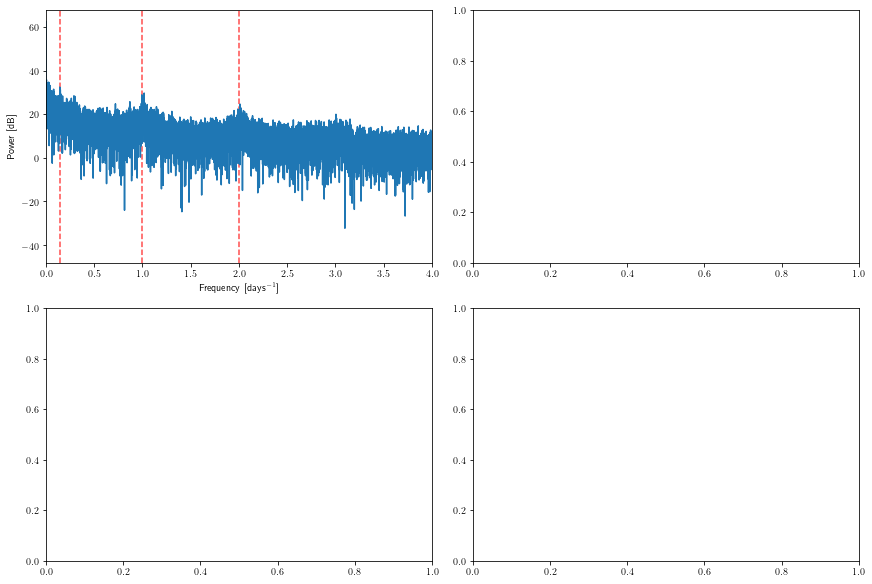

In [6]:
Fs = 24 #Sampling rate [Hz]
n = len(PM10_train)
fr = np.fft.rfftfreq(n, d=1/Fs)
fig, axs = plt.subplots(len(stations)//2,2, figsize=(12,8), constrained_layout=True)
#fig.tight_layout()
for ax,stat in zip(axs.reshape(-1),stations):
    pm10_fft = abs(np.fft.rfft(PM10_train[stat].values))
    pm10_fft_power = 10*np.log10((1/(Fs*n))*pm10_fft**2)

    ax.axis(xmin=0, xmax=4)
    freqs = [1/7, 1, 2]
    for f in freqs:
        ax.axvline(f, color='r', alpha=0.7, linestyle='--')
    ax.plot(fr, pm10_fft_power)
    ax.set_xlabel(r"Frequency [days$^{-1}$]")
    ax.set_ylabel(r"Power [dB]")
    ax.set_title(f'{stat}, {stat_types[stations.index(stat)]}')


### 2.3 Boxplots

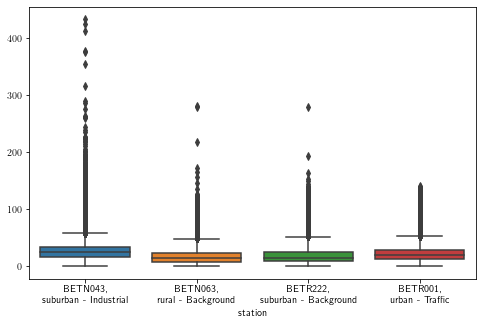

In [7]:
import seaborn as sns
plt.figure(figsize=(8,5))
ax = plt.gca()
sns.boxplot(data=PM10_train)
ax.set_xticklabels(f'{stat},\n{t}' for stat, t in zip(stations,types))
plt.show()

### 2.3 Autocorrelation
Hourly data

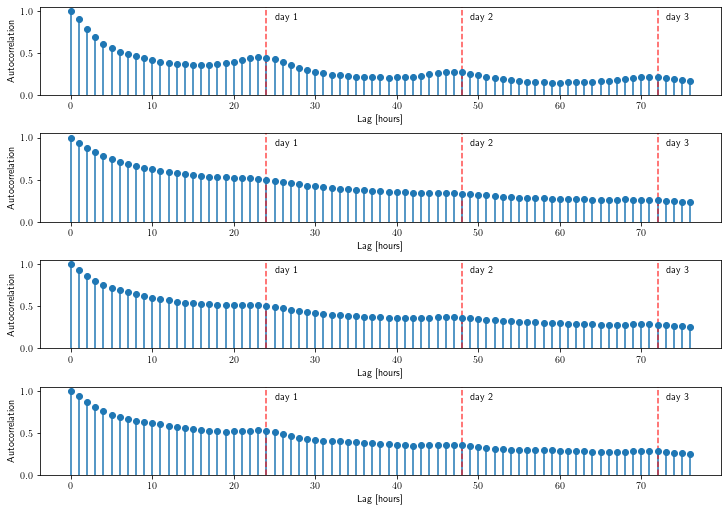

In [8]:
fig, axs = plt.subplots(len(stations),1, figsize=(10,7), constrained_layout=True)
for ax,stat in zip(axs,stations):
    pm10 = PM10_train[stat].values
    pm10_0m = pm10-np.mean(pm10)
    auto_corr = np.correlate(pm10_0m, pm10_0m, mode='same')
    auto_corr = auto_corr[auto_corr.size//2:]/auto_corr[auto_corr.size//2]
    days = 3
    for d in range(days):
        ax.axvline(24*(d+1), color='r', alpha=0.7, linestyle='--')
        ax.text(24*(d+1)+1,0.9,f'day {d+1}',rotation=0)
    ax.stem(auto_corr[:24*days+5], basefmt=' ', use_line_collection=True)
    ax.axis(ymin=0)
    ax.set_xlabel('Lag [hours]')
    ax.set_ylabel('Autocorrelation')

Daily data

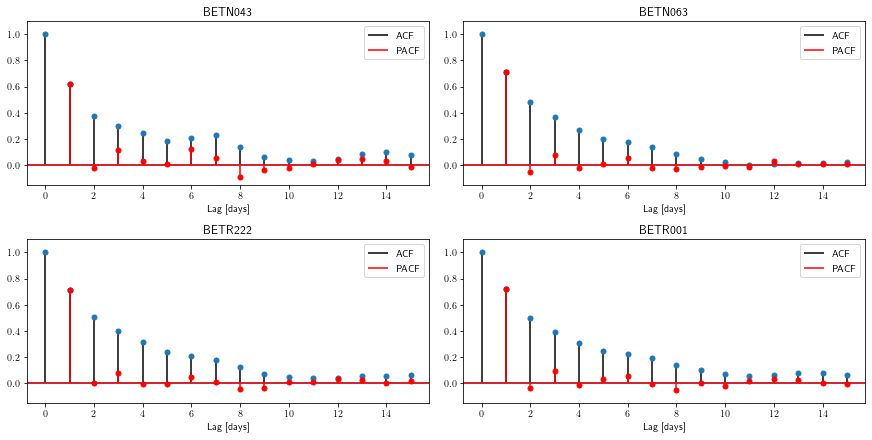

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

fig,axs = plt.subplots(len(stations)//2,2, figsize=(12,6), constrained_layout=True)
lags = 15
for ax, stat in zip(axs.reshape(-1),stations):
    plt.sca(ax)
    plot_acf(PM10_train_D[stat].values, ax=ax, lags=lags, alpha=None, vlines_kwargs={'label':'ACF'})
    plot_pacf(PM10_train_D[stat].values, ax=ax, lags=lags, method='ywm', color='r', zero=False, alpha=None, vlines_kwargs={'color':'r', 'label':'PACF'})
    plt.ylim(-0.15,1.1)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Lag [days]')
    plt.title(stat)
    plt.legend()


The regular autocorrelation plot (blue), shows significant correlation with up to around 10 days in the past. The partial autocorrelation shows, however, that most of this correlation is explained by the prior day (lag=1). This suggests that including more than 1 prior day will not significantly increase prediction performance.

### 2.4 Prediction
#### 2.4.1 ARIMA

In [86]:
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

class ArimaModel:
    def __init__(self, p,d,q):
        self.p = p
        self.d = d
        self.q = q

    def fit(self, X):
        self.xtrain = X
        self.fit = ARIMA(X, order=(self.p, self.d, self.q)).fit()

    def predict(self, X_new):
        # Compute the first forecast based only on the training dataset
        forecasts = np.empty(len(X_new))
        fit = self.fit
        # Now step through the test observations:
        # (a) add the new observation without refitting the model
        # (b) produce a new forecast
        for i,x in enumerate(X_new):
            # Predict current observation
            forecasts[i] = fit.forecast()[0]
            # Add observation for next prediction
            fit = fit.append([x], refit=False)
        return forecasts


arima_models = {}

for stat in stations:
    arima_model = pm.auto_arima(PM10_train_D[stat].dropna().values, start_p=1, start_q=1,
                        test='adf',       # use adftest to find optimal 'd'
                        max_p=6, max_q=6, # maximum p and q
                        m=1,              # frequency of series
                        d=None,           # let model determine 'd'
                        seasonal=False,   # No Seasonality
                        start_P=0, 
                        D=0, 
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

    arima_model = ArimaModel(*arima_model.order)
    arima_model.fit(PM10_train_D[stat].dropna().values)
    arima_models[stat] = arima_model

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=16991.094, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=21371.037, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=17085.882, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=19436.519, Time=0.30 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=1.68 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=16784.061, Time=0.50 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=18522.145, Time=0.46 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=16696.647, Time=1.20 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.91 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=2.13 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=16738.982, Time=0.93 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=16698.181, Time=1.65 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=2.17 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=16679.018, Time=2.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1

/usr/local/Caskroom/miniconda/base/envs/PM/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [58]:
for stat in stations:
    print(arima_models[stat]._model_params)

OrderedDict([('p', 1), ('d', 1), ('q', 2), ('seasonal_order', (0, 0, 0, 0)), ('trend', None), ('random_state', 0)])
OrderedDict([('p', 1), ('d', 0), ('q', 2), ('seasonal_order', (0, 0, 0, 0)), ('trend', None), ('random_state', 0)])
OrderedDict([('p', 1), ('d', 0), ('q', 2), ('seasonal_order', (0, 0, 0, 0)), ('trend', None), ('random_state', 0)])
OrderedDict([('p', 1), ('d', 1), ('q', 2), ('seasonal_order', (0, 0, 0, 0)), ('trend', None), ('random_state', 0)])


#### 2.4.2 SVR

In [70]:
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline



In [72]:
max_lag = 5
metrics = eval.metrics
cols = pd.MultiIndex.from_product([metrics.keys(), stations])
idx = pd.Index(range(1, max_lag+1), name='Lags')
lag_res = pd.DataFrame(columns=cols, index=idx)
tscv = TimeSeriesSplit(n_splits=4)
svm_param_grid = [{'svr__kernel': ['rbf'], 
            'svr__gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5],
            'svr__C': [1, 10, 100, 1000],
            'svr__epsilon': [0.001, 0.01, 0.1]}]

svm_param_distr = [{'svr__kernel': ['rbf'], 
            'svr__gamma': sp.stats.expon(scale=0.1),
            'svr__C': sp.stats.expon(scale=100),
            'svr__epsilon': sp.stats.expon(scale=0.1)}]



svr_models = {}
for stat in stations:
    print(f'Station: {stat}')
    Xy_train_full = np.vstack([PM10_train_D[stat].shift(i) for i in reversed(range(-1,max_lag))]).T
    Xy_val_full = np.vstack([PM10_val_D[stat].shift(i) for i in reversed(range(-1,max_lag))]).T
    for lag in range(1, max_lag+1):
        # Select columns according to the lag
        Xy_train = Xy_train_full[:,max_lag-lag:]
        Xy_val = Xy_val_full[:,max_lag-lag:]
        # Remove NaN rows
        Xy_train = Xy_train[~np.isnan(Xy_train).any(axis=1)]
        scaler = StandardScaler()
        pipe = Pipeline(steps=[("scaler", scaler), ("svr", SVR())])
        
        search = RandomizedSearchCV(pipe,
                                svm_param_distr,
                                n_iter=10,
                                cv = tscv,
                                scoring="neg_mean_squared_error",
                                verbose=1,
                                refit=True)
        search.fit(Xy_train[:,:-1], Xy_train[:,-1])
        print(search.best_params_)
        model = search.best_estimator_
        model.predict = helper.nan_handler(model.predict)
        svr_models[stat] = model
        y_val_pred = model.predict(Xy_val[:,:-1])
        for metr, val in eval.evaluate(Xy_val[:,-1], y_val_pred).items():
            lag_res[(metr, stat)][lag] = val
        


Station: BETN043
Fitting 4 folds for each of 10 candidates, totalling 40 fits
{'svr__C': 57.732431092959615, 'svr__epsilon': 0.44544973806090526, 'svr__gamma': 0.010763511253529057, 'svr__kernel': 'rbf'}
Fitting 4 folds for each of 10 candidates, totalling 40 fits
{'svr__C': 59.637940577871916, 'svr__epsilon': 0.3843006793847038, 'svr__gamma': 0.012352664697169054, 'svr__kernel': 'rbf'}
Fitting 4 folds for each of 10 candidates, totalling 40 fits
{'svr__C': 17.73255791111865, 'svr__epsilon': 0.095596641564887, 'svr__gamma': 0.013218371012746116, 'svr__kernel': 'rbf'}
Fitting 4 folds for each of 10 candidates, totalling 40 fits
{'svr__C': 114.11378934861136, 'svr__epsilon': 0.008915428868611115, 'svr__gamma': 0.005807236011760493, 'svr__kernel': 'rbf'}
Fitting 4 folds for each of 10 candidates, totalling 40 fits
{'svr__C': 34.55195781766234, 'svr__epsilon': 0.02755279406181342, 'svr__gamma': 0.010568717152126388, 'svr__kernel': 'rbf'}
Station: BETN063
Fitting 4 folds for each of 10 cand

In [73]:
lag_res

smape                                        mae            \
        BETN043    BETN063    BETR222    BETR001   BETN043   BETN063   
Lags                                                                   
1     28.216855  46.088122  42.047096  27.410744  7.601902   5.81556   
2     28.190344  45.676044  42.230791  27.898265  7.612398  5.818544   
3     28.974214  46.042828  41.920712  27.630768  7.865494  5.876219   
4     29.017648  45.683383  41.508939   27.84462   7.95052  5.813023   
5     28.663427   45.70532  41.890949  27.420269   7.89948  5.781492   

                              mase                                     rmse  \
       BETR222   BETR001   BETN043   BETN063   BETR222   BETR001    BETN043   
Lags                                                                          
1     8.240008  5.536031  0.907996  0.943516    0.9475  0.935909  10.733752   
2     8.197823   5.70036   0.90925     0.944  0.942649   0.96369  10.764372   
3     8.059091  5.733792  0.939481  0.953357  0.926697  0.969342  11.026203   
4     7.925715  5.790417  0.949636  0.943104   0.91136  0.978914   11.22306   
5      7.99858  5.764092   0.94354  0.937989  0.919739  0.974464  11.224349   

                                     
       BETN063    BETR222   BETR001  
Lags                                 
1     7.921525   12.68571   7.49189  
2      7.93406  12.652514  7.632301  
3     8.019303  12.446681  7.781286  
4     7.954894  12.260837  7.757552  
5     7.934206  12.401209  7.751684

As suggested by the partial autocorrelation plots above, using a larger observation window does not improve performance:

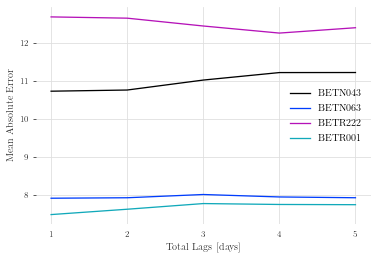

In [75]:
lag_res['rmse'].plot()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Total Lags [days]')
plt.ylabel('Mean Absolute Error')
plt.show()

In [76]:
lag = 1
svr1_models = {}
tscv = TimeSeriesSplit(n_splits=6)

for stat in stations:
    Xy_train = np.vstack([PM10_train_D[stat].shift(i) for i in reversed(range(0,lag+1))]).T

    # Remove NaN rows
    Xy_train = Xy_train[~np.isnan(Xy_train).any(axis=1), :]

    scaler = StandardScaler()
    pipe = Pipeline(steps=[("scaler", scaler), ("svr", SVR())])

    svm_params = [{'svr__kernel': ['rbf'], 
                    'svr__gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5],
                    'svr__C': [1, 10, 100, 1000],
                    'svr__epsilon': [0.001, 0.01, 0.1]}]

    search = RandomizedSearchCV(pipe,
                                svm_param_distr,
                                n_iter=15,
                                cv = tscv,
                                scoring="neg_mean_squared_error",
                                verbose=1,
                                refit=True)
    search.fit(Xy_train[:,:-1], Xy_train[:,-1].flatten())
    print(search.best_params_)
    model = search.best_estimator_ #Can't handle NaN values
    model.predict = helper.nan_handler(model.predict)
    svr1_models[stat] = model

Fitting 6 folds for each of 15 candidates, totalling 90 fits
{'svr__C': 71.58464457141056, 'svr__epsilon': 0.008696517411408913, 'svr__gamma': 0.005242602006781658, 'svr__kernel': 'rbf'}
Fitting 6 folds for each of 15 candidates, totalling 90 fits
{'svr__C': 18.18691431587448, 'svr__epsilon': 0.027508231136862227, 'svr__gamma': 0.02491388961250461, 'svr__kernel': 'rbf'}
Fitting 6 folds for each of 15 candidates, totalling 90 fits
{'svr__C': 141.63683060101388, 'svr__epsilon': 0.022767999050922236, 'svr__gamma': 0.08354289879047352, 'svr__kernel': 'rbf'}
Fitting 6 folds for each of 15 candidates, totalling 90 fits
{'svr__C': 157.3676850585548, 'svr__epsilon': 0.07992584930958004, 'svr__gamma': 0.07599829999062921, 'svr__kernel': 'rbf'}


Use hourly concentrations

In [77]:
cols = pd.MultiIndex.from_product([stations, range(24)])
idx = PM10_train.index.map(lambda t: t.date()).unique()
PM10_24_train = pd.DataFrame(index = idx, columns = cols, dtype = np.float64)
idx = PM10_val.index.map(lambda t: t.date()).unique()
PM10_24_val = pd.DataFrame(index = idx, columns = cols, dtype = np.float64)
for hour in range(24):
    idx_train = PM10_train[PM10_train.index.hour == hour].index
    idx_val = PM10_val[PM10_val.index.hour == hour].index
    PM10_24_train.loc[idx_train.date,(slice(None),hour)] = PM10_train.loc[idx_train].values
    PM10_24_val.loc[idx_val.date,(slice(None),hour)] = PM10_val.loc[idx_val].values
PM10_24_train = PM10_24_train.shift(1)
PM10_24_val = PM10_24_val.shift(1)

n_hours = [12, 24]
svr_hours_models = {h:{} for h in n_hours}

for stat in stations:
    for h in n_hours:
        Xy_train = np.hstack([PM10_24_train[stat][range(h)].values, PM10_train_D[stat].values.reshape(-1,1)])
        # Remove NaN rows
        Xy_train = Xy_train[~np.isnan(Xy_train).any(axis=1), :]

        scaler = StandardScaler()
        pipe = Pipeline(steps=[("scaler", scaler), ("svr", SVR())])

        # TODO: other kernels, alternative search methods
        search = RandomizedSearchCV(pipe,
                                svm_param_distr,
                                n_iter=15,
                                cv = tscv,
                                scoring="neg_mean_squared_error",
                                verbose=1,
                                refit=True)

        search.fit(Xy_train[:,:-1], Xy_train[:,-1].flatten())
        print(search.best_params_)
        model = search.best_estimator_ #Can't handle NaN values
        model.predict = helper.nan_handler(model.predict)
        svr_hours_models[h][stat] = model

Fitting 6 folds for each of 15 candidates, totalling 90 fits
{'svr__C': 5.0766847996422415, 'svr__epsilon': 0.010742332539678025, 'svr__gamma': 0.01440708963877635, 'svr__kernel': 'rbf'}
Fitting 6 folds for each of 15 candidates, totalling 90 fits
{'svr__C': 0.11168080791881126, 'svr__epsilon': 0.021902684395421507, 'svr__gamma': 0.033847243964295254, 'svr__kernel': 'rbf'}
Fitting 6 folds for each of 15 candidates, totalling 90 fits
{'svr__C': 208.49950960347078, 'svr__epsilon': 0.004370441339669108, 'svr__gamma': 3.6741123870157884e-05, 'svr__kernel': 'rbf'}
Fitting 6 folds for each of 15 candidates, totalling 90 fits
{'svr__C': 3.9830049122058795, 'svr__epsilon': 0.05714007373194292, 'svr__gamma': 0.11015537817229817, 'svr__kernel': 'rbf'}
Fitting 6 folds for each of 15 candidates, totalling 90 fits
{'svr__C': 25.64370562179838, 'svr__epsilon': 0.0015863400710966003, 'svr__gamma': 0.03943098233112871, 'svr__kernel': 'rbf'}
Fitting 6 folds for each of 15 candidates, totalling 90 fits


## 3. Evaluation

In [94]:
models = ['Arima', 'Persistence', 'SVR_1day'] + [f'SVR_{h}h' for h in svr_hours_models.keys()]
metrics = eval.metrics
cols = pd.MultiIndex.from_product([metrics.keys(), models])
metric_df = pd.DataFrame(columns = cols, index = stations)
cols = pd.MultiIndex.from_product([stations, models])
results = pd.DataFrame(columns=cols, index = PM10_val_D.index)

for stat in stations:
    print(f'Station: {stat}')
    y_true = PM10_val_D[stat].values

    # Persistence
    y_persistence = np.concatenate([[np.NaN], y_true[:-1]])
    results[stat,'Persistence'] = y_persistence


    # Arima
    results[stat,'Arima'] = arima_models[stat].predict(PM10_val_D[stat])


    # SVR_1day
    X_val = np.vstack([PM10_val_D[stat].shift(i) for i in reversed(range(1,lag+1))]).T
    y_svr_1day = svr1_models[stat].predict(X_val)

    results[stat,'SVR_1day'] = y_svr_1day

    # SVR_24hours
    for h in svr_hours_models.keys():
        y_svr_h = svr_hours_models[h][stat].predict(PM10_24_val[stat][range(h)].values)

        for metr, val in eval.evaluate(y_true, y_svr_h).items():
            metric_df.loc[stat, (metr, f'SVR_{h}h')] = val


for stat in stations:
    print(f'Station: {stat}')
    y_true = PM10_val_D[stat].values

    # Persistence
    y_persistence = np.concatenate([[np.NaN], y_true[:-1]])
    results[stat,'Persistence'] = y_persistence
    for metr, val in eval.evaluate(y_true, y_persistence).items():
            metric_df.loc[stat, (metr, 'Persistence')] = val

    # Arima
    y_arima = arima_models[stat].predict(PM10_val_D[stat])
    for metr, val in eval.evaluate(y_true, y_arima).items():
        metric_df.loc[stat, (metr, 'Arima')] = val

    # SVR_1day
    X_val = np.vstack([PM10_val_D[stat].shift(i) for i in reversed(range(1,lag+1))]).T
    y_svr_1day = svr1_models[stat].predict(X_val)

    for metr, val in eval.evaluate(y_true, y_svr_1day).items():
        metric_df.loc[stat, (metr, f'SVR_1day')] = val

    # SVR_24hours
    for h in svr_hours_models.keys():
        y_svr_h = svr_hours_models[h][stat].predict(PM10_24_val[stat][range(h)].values)

        for metr, val in eval.evaluate(y_true, y_svr_h).items():
            metric_df.loc[stat, (metr, f'SVR_{h}h')] = val


pd.options.display.float_format = "{:,.2f}".format
metric_df.T

Station: BETN043
Station: BETN063
Station: BETR222
Station: BETR001


BETN043 BETN063 BETR222 BETR001
smape Arima         29.77   47.46   42.80   28.61
      Persistence   30.31   48.01   44.07   29.14
      SVR_1day      28.22   45.35   42.11   27.34
      SVR_12h       33.44   57.01   53.09   35.08
      SVR_24h       34.10   55.83   51.29   32.99
mae   Arima          7.91    5.98    8.29    5.66
      Persistence    8.34    6.16    8.68    5.91
      SVR_1day       7.60    5.79    8.29    5.52
      SVR_12h        9.43    7.50   10.42    7.30
      SVR_24h        9.87    7.31    9.92    6.88
mase  Arima          0.95    0.97    0.95    0.96
      Persistence    1.00    1.00    1.00    1.00
      SVR_1day       0.91    0.94    0.95    0.93
      SVR_12h        1.13    1.22    1.20    1.24
      SVR_24h        1.18    1.19    1.14    1.16
rmse  Arima         10.66    8.00   12.46    7.50
      Persistence   11.74    8.63   13.64    8.11
      SVR_1day      10.75    7.92   12.78    7.48
      SVR_12h       13.31    9.72   15.58    9.62
      SVR_24h       14.04    9.58   15.05    9.61

In [95]:
results

BETN043                                       \
                            Arima Persistence SVR_1day SVR_12h SVR_24h   
time                                                                     
2019-01-01 00:00:00+01:00     NaN         NaN      NaN     NaN     NaN   
2019-01-02 00:00:00+01:00     NaN       17.00      NaN     NaN     NaN   
2019-01-03 00:00:00+01:00     NaN       17.40      NaN     NaN     NaN   
2019-01-04 00:00:00+01:00     NaN       14.27      NaN     NaN     NaN   
2019-01-05 00:00:00+01:00     NaN       25.33      NaN     NaN     NaN   
...                           ...         ...      ...     ...     ...   
2019-12-27 00:00:00+01:00     NaN         NaN      NaN     NaN     NaN   
2019-12-28 00:00:00+01:00     NaN         NaN      NaN     NaN     NaN   
2019-12-29 00:00:00+01:00     NaN         NaN      NaN     NaN     NaN   
2019-12-30 00:00:00+01:00     NaN       27.32      NaN     NaN     NaN   
2019-12-31 00:00:00+01:00     NaN         NaN      NaN     NaN     NaN   

                          BETN063                                       \
                            Arima Persistence SVR_1day SVR_12h SVR_24h   
time                                                                     
2019-01-01 00:00:00+01:00     NaN         NaN      NaN     NaN     NaN   
2019-01-02 00:00:00+01:00     NaN       13.54      NaN     NaN     NaN   
2019-01-03 00:00:00+01:00     NaN       10.06      NaN     NaN     NaN   
2019-01-04 00:00:00+01:00     NaN       11.25      NaN     NaN     NaN   
2019-01-05 00:00:00+01:00     NaN       27.90      NaN     NaN     NaN   
...                           ...         ...      ...     ...     ...   
2019-12-27 00:00:00+01:00     NaN       12.38      NaN     NaN     NaN   
2019-12-28 00:00:00+01:00     NaN       15.80      NaN     NaN     NaN   
2019-12-29 00:00:00+01:00     NaN       22.02      NaN     NaN     NaN   
2019-12-30 00:00:00+01:00     NaN       15.65      NaN     NaN     NaN   
2019-12-31 00:00:00+01:00     NaN       11.31      NaN     NaN     NaN   

                          BETR222                                       \
                            Arima Persistence SVR_1day SVR_12h SVR_24h   
time                                                                     
2019-01-01 00:00:00+01:00     NaN         NaN      NaN     NaN     NaN   
2019-01-02 00:00:00+01:00     NaN       21.10      NaN     NaN     NaN   
2019-01-03 00:00:00+01:00     NaN       17.58      NaN     NaN     NaN   
2019-01-04 00:00:00+01:00     NaN       21.35      NaN     NaN     NaN   
2019-01-05 00:00:00+01:00     NaN       34.31      NaN     NaN     NaN   
...                           ...         ...      ...     ...     ...   
2019-12-27 00:00:00+01:00     NaN       12.46      NaN     NaN     NaN   
2019-12-28 00:00:00+01:00     NaN       12.27      NaN     NaN     NaN   
2019-12-29 00:00:00+01:00     NaN       16.90      NaN     NaN     NaN   
2019-12-30 00:00:00+01:00     NaN       22.50      NaN     NaN     NaN   
2019-12-31 00:00:00+01:00     NaN       22.77      NaN     NaN     NaN   

                          BETR001                                       
                            Arima Persistence SVR_1day SVR_12h SVR_24h  
time                                                                    
2019-01-01 00:00:00+01:00     NaN         NaN      NaN     NaN     NaN  
2019-01-02 00:00:00+01:00     NaN       13.73      NaN     NaN     NaN  
2019-01-03 00:00:00+01:00     NaN       18.08      NaN     NaN     NaN  
2019-01-04 00:00:00+01:00     NaN       12.96      NaN     NaN     NaN  
2019-01-05 00:00:00+01:00     NaN       21.69      NaN     NaN     NaN  
...                           ...         ...      ...     ...     ...  
2019-12-27 00:00:00+01:00     NaN       18.21      NaN     NaN     NaN  
2019-12-28 00:00:00+01:00     NaN       15.85      NaN     NaN     NaN  
2019-12-29 00:00:00+01:00     NaN       17.12      NaN     NaN     NaN  
2019-12-30 00:00:00+01:00     NaN      